<a href="https://colab.research.google.com/github/fazalpge/product_forecasting/blob/main/Multivariate_multiple_timeseries_forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [35]:
class LSTMModel(BaseEstimator, TransformerMixin):
    def __init__(self, periods=30, look_back=1):
        self.periods = periods
        self.look_back = look_back
        self.models = {}
        self.scalers = {}

    def fit(self, X, y=None):
        unique_combinations = X[['Location', 'ItemName']].drop_duplicates()
        for _, row in unique_combinations.iterrows():
            location, item_name = row['Location'], row['ItemName']
            sub_df = self._prepare_sub_df(X, location, item_name)
            print(f"Training model for Location: {location}, ItemName: {item_name}")
            print(f"Data shape: {sub_df.shape}")
            if sub_df.dropna().shape[0] > self.look_back:
                model, scaler = self._train_lstm_model(sub_df)
                self.models[(location, item_name)] = model
                self.scalers[(location, item_name)] = scaler
            else:
                print(f"Skipping combination Location: {location}, ItemName: {item_name} due to insufficient data")
        return self

    def _prepare_sub_df(self, X, location, item_name):
        sub_df = X[(X['Location'] == location) & (X['ItemName'] == item_name)].copy()
        sub_df = sub_df.rename(columns={'TransactionDate': 'ds', 'SaleAmount': 'y', 'SaleBonusQty': 'bonus_qty'})
        sub_df['ds'] = pd.to_datetime(sub_df['ds'], format='%Y-%m-%d')
        sub_df['bonus_qty'] = sub_df['bonus_qty'].fillna(0)
        return sub_df

    def _train_lstm_model(self, sub_df):
        dataset = sub_df[['y', 'bonus_qty']].values
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)

        trainX, trainY = [], []
        for i in range(len(dataset) - self.look_back):
            a = dataset[i:(i + self.look_back), :]
            trainX.append(a)
            trainY.append(dataset[i + self.look_back, 0])
        trainX, trainY = np.array(trainX), np.array(trainY)

        print(f"trainX shape: {trainX.shape}, trainY shape: {trainY.shape}")

        if trainX.size == 0 or trainY.size == 0:
            raise ValueError("Training data is empty. Please check the data preparation steps.")

        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=(self.look_back, 2)))
        model.add(LSTM(50))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
        return model, scaler

    def transform(self, X, interval='daily', location=None, item_name=None):
        forecast_df = pd.DataFrame()
        filtered_X = self._filter_data(X, location, item_name)
        unique_combinations = filtered_X[['Location', 'ItemName']].drop_duplicates()
        for _, row in unique_combinations.iterrows():
            loc, itm = row['Location'], row['ItemName']
            if (loc, itm) in self.models:
                model = self.models[(loc, itm)]
                scaler = self.scalers[(loc, itm)]
                forecast = self._make_forecast(model, scaler, filtered_X, loc, itm, interval)
                forecast_df = pd.concat([forecast_df, forecast], ignore_index=True)
        return forecast_df

    def _filter_data(self, X, location, item_name):
        if location and item_name:
            return X[(X['Location'] == location) & (X['ItemName'] == item_name)]
        elif location:
            return X[X['Location'] == location]
        elif item_name:
            return X[X['ItemName'] == item_name]
        else:
            return X

    def _make_forecast(self, model, scaler, X, location, item_name, interval):
        sub_df = self._prepare_sub_df(X, location, item_name)
        dataset = sub_df[['y', 'bonus_qty']].values
        dataset = scaler.transform(dataset)
        predictions = []

        for i in range(len(dataset) - self.look_back):
            seq = dataset[i:(i + self.look_back), :]
            seq = np.expand_dims(seq, axis=0)
            prediction = model.predict(seq)
            predictions.append(prediction[0, 0])

        predictions = np.array(predictions)
        predictions = scaler.inverse_transform(np.c_[predictions, np.zeros(predictions.shape)])
        forecast_dates = sub_df['ds'].iloc[self.look_back:].reset_index(drop=True)

        forecast_df = pd.DataFrame({
            'ds': forecast_dates,
            'yhat': predictions[:, 0],
            'Location': location,
            'ItemName': item_name
        })
        return forecast_df

    def plot_forecast(self, X, interval='daily', location=None, item_name=None):
        forecast_df = self.transform(X, interval=interval, location=location, item_name=item_name)
        self._plot(forecast_df, location, item_name)

    def _plot(self, forecast_df, location, item_name):
        plt.figure(figsize=(10, 6))
        plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Forecast')
        if location and item_name:
            title = f'Forecast for {location} - {item_name}'
        elif location:
            title = f'Forecast for {location}'
        elif item_name:
            title = f'Forecast for {item_name}'
        else:
            title = 'Forecast'
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('SaleAmount')
        plt.legend()
        plt.show()

In [28]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/fazalpge/product_forecasting/main/Inventory%20Data_fazal.csv')


In [29]:
df.isnull().sum()

TransactionDate            0
Location                   0
ItemName                   0
Cost                       0
SaleQty                    0
SaleBonusQty               0
SaleTotalQty               0
MRP                        0
SaleAmount                 0
PerInvoiceAverageAmount    0
dtype: int64

In [32]:
# Ensure the date column is in datetime format
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

<ipython-input-32-af55811504b3>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])


In [20]:
# Rename 'TransactionDate' to 'ds' and 'SaleBonusQty' to 'bonus_qty' for consistency
#df = df.rename(columns={'TransactionDate': 'ds', 'SaleBonusQty': 'bonus_qty'})

In [37]:
# Create the pipeline
pipeline = Pipeline([
    ('lstm', LSTMModel(periods=30, look_back=5))
])

In [9]:
pipeline

Pipeline(steps=[('lstm', LSTMModel(look_back=5))])

In [38]:
# Fit the pipeline
pipeline.fit(df)

Training model for Location: Brahmaputra, ItemName: Clean 100ml
Data shape: (203, 10)
trainX shape: (198, 5, 2), trainY shape: (198,)
Epoch 1/20
198/198 - 4s - loss: 0.0160 - 4s/epoch - 22ms/step
Epoch 2/20
198/198 - 1s - loss: 0.0165 - 1s/epoch - 5ms/step
Epoch 3/20
198/198 - 1s - loss: 0.0159 - 980ms/epoch - 5ms/step
Epoch 4/20
198/198 - 1s - loss: 0.0154 - 933ms/epoch - 5ms/step
Epoch 5/20
198/198 - 1s - loss: 0.0155 - 1s/epoch - 6ms/step
Epoch 6/20
198/198 - 1s - loss: 0.0156 - 1s/epoch - 7ms/step
Epoch 7/20
198/198 - 1s - loss: 0.0157 - 1s/epoch - 7ms/step
Epoch 8/20
198/198 - 1s - loss: 0.0155 - 1s/epoch - 6ms/step
Epoch 9/20
198/198 - 1s - loss: 0.0154 - 966ms/epoch - 5ms/step
Epoch 10/20
198/198 - 1s - loss: 0.0155 - 895ms/epoch - 5ms/step
Epoch 11/20
198/198 - 1s - loss: 0.0152 - 882ms/epoch - 4ms/step
Epoch 12/20
198/198 - 1s - loss: 0.0152 - 893ms/epoch - 5ms/step
Epoch 13/20
198/198 - 1s - loss: 0.0151 - 975ms/epoch - 5ms/step
Epoch 14/20
198/198 - 1s - loss: 0.0152 - 972ms

Pipeline(steps=[('lstm', LSTMModel(look_back=5))])

In [39]:
forecast_df = pipeline.named_steps['lstm'].transform(df, location='Brahmaputra', item_name='Clean 100ml', interval='weekly')
print(forecast_df.head())

1/1 [==============================] - 0s 35ms/step
          ds          yhat     Location     ItemName
0 2023-10-16  20936.957181  Brahmaputra  Clean 100ml
1 2023-10-16   8990.696818  Brahmaputra  Clean 100ml
2 2023-10-15  22132.538080  Brahmaputra  Clean 100ml
3 2023-10-08  24798.149228  Brahmaputra  Clean 100ml
4 2023-10-04  24549.604595  Brahmaputra  Clean 100ml


1/1 [==============================] - 0s 23ms/step


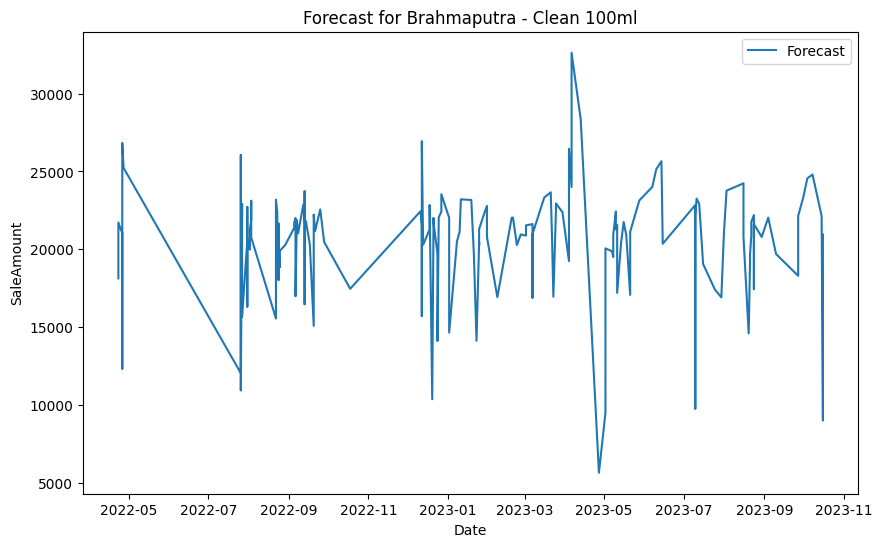

In [41]:
# Example of plotting the forecast for a specific Location and ItemName
pipeline.named_steps['lstm'].plot_forecast(df, interval='weekly', location='Brahmaputra', item_name='Clean 100ml')

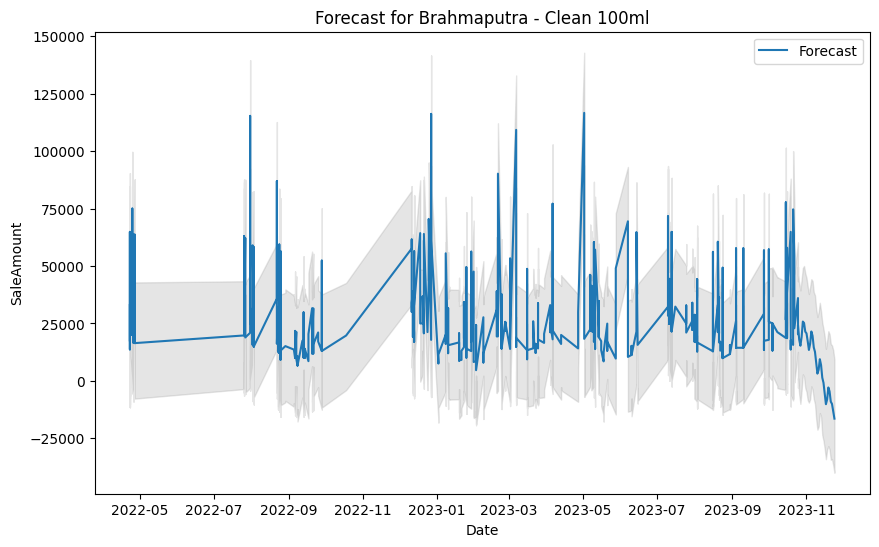

In [ ]:
# Example of plotting the forecast for a specific Location and ItemName
pipeline.named_steps['prophet'].plot_forecast(forecast_df, location='Brahmaputra', item_name='Clean 100ml')

In [ ]:
# Example of generating and displaying weekly forecast
weekly_forecast_df=pipeline.named_steps['prophet'].transform(df, location='Brahmaputra', item_name='Clean 100ml',interval='weekly')
weekly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-7668.983251,42056.163897,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,-5871.973125,43149.748605,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-7422.428362,43108.871562,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,-5788.484589,41794.479002,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,-7417.339846,40460.020551,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,2024-04-21,13952.970111,-3761.208922,44551.001028,13952.966801,13952.973783,7427.433887,7427.433887,7427.433887,0.000,...,4715.368631,2712.065256,2712.065256,2712.065256,0.0,0.0,0.0,21380.403998,Brahmaputra,Clean 100ml
229,2024-04-28,13963.521173,-2863.366999,47217.951735,13963.517670,13963.525015,8282.359008,8282.359008,8282.359008,0.000,...,4715.368631,3566.990377,3566.990377,3566.990377,0.0,0.0,0.0,22245.880181,Brahmaputra,Clean 100ml
230,2024-05-05,13974.072236,-339.677086,46292.123387,13974.068557,13974.076290,9174.570867,9174.570867,9174.570867,0.000,...,4715.368631,4459.202236,4459.202236,4459.202236,0.0,0.0,0.0,23148.643103,Brahmaputra,Clean 100ml
231,2024-05-12,13984.623299,-5286.249317,45346.188646,13984.619454,13984.627501,6518.036391,6518.036391,6518.036391,0.000,...,4715.368631,1802.667760,1802.667760,1802.667760,0.0,0.0,0.0,20502.659690,Brahmaputra,Clean 100ml


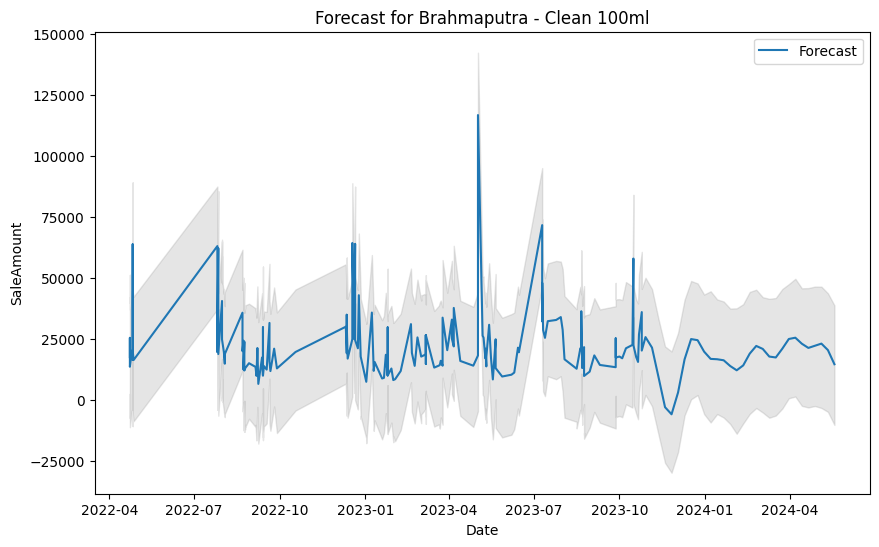

In [ ]:
# Example of plotting the forecast for a specific Location and ItemName
pipeline.named_steps['prophet'].plot_forecast(df, location='Brahmaputra', item_name='Clean 100ml', interval='weekly')

In [ ]:
pipeline.named_steps['prophet'].transform(df, location='Brahmaputra', item_name='Clean 100ml',interval='weekly')

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-7337.125122,41433.543650,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,-5822.398704,42770.469728,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-7532.776470,41813.394628,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,-4253.325471,42161.185487,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,-7184.237589,42474.994626,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,2024-04-21,13952.970111,-2435.189382,45190.767260,13952.966857,13952.973186,7427.433887,7427.433887,7427.433887,0.000,...,4715.368631,2712.065256,2712.065256,2712.065256,0.0,0.0,0.0,21380.403998,Brahmaputra,Clean 100ml
229,2024-04-28,13963.521173,-1696.669702,48691.118815,13963.517665,13963.524385,8282.359008,8282.359008,8282.359008,0.000,...,4715.368631,3566.990377,3566.990377,3566.990377,0.0,0.0,0.0,22245.880181,Brahmaputra,Clean 100ml
230,2024-05-05,13974.072236,-835.203781,48589.580472,13974.068519,13974.075597,9174.570867,9174.570867,9174.570867,0.000,...,4715.368631,4459.202236,4459.202236,4459.202236,0.0,0.0,0.0,23148.643103,Brahmaputra,Clean 100ml
231,2024-05-12,13984.623299,-3111.450701,44704.782224,13984.619381,13984.626843,6518.036391,6518.036391,6518.036391,0.000,...,4715.368631,1802.667760,1802.667760,1802.667760,0.0,0.0,0.0,20502.659690,Brahmaputra,Clean 100ml


In [ ]:
# Example of generating and displaying monthly forecast
monthly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='monthly')
monthly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-6102.889528,42013.980750,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,9512.108565,60382.031468,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-10030.324810,37364.675637,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,38507.791860,88606.754305,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,36372.892801,85607.457613,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921,2025-11-30,8332.480457,-43362.506705,6313.082783,8332.387748,8332.575532,-28415.089372,-28415.089372,-28415.089372,0.000,...,-2038.036593,-26377.052779,-26377.052779,-26377.052779,0.0,0.0,0.0,-20082.608916,Turag,Clean 100ml
8922,2025-12-31,7952.433088,-14617.924684,34160.842591,7952.335205,7952.535253,2698.103334,2698.103334,2698.103334,0.000,...,-77.029606,2775.132940,2775.132940,2775.132940,0.0,0.0,0.0,10650.536422,Turag,Clean 100ml
8923,2026-01-31,7572.385719,-27494.952300,23478.727287,7572.282605,7572.493153,-9054.768713,-9054.768713,-9054.768713,0.000,...,-3434.972866,-5619.795847,-5619.795847,-5619.795847,0.0,0.0,0.0,-1482.382994,Turag,Clean 100ml
8924,2026-02-28,7229.117128,2945.779881,54326.329559,7229.006962,7229.229881,20463.762118,20463.762118,20463.762118,0.000,...,-3434.972866,23898.734984,23898.734984,23898.734984,0.0,0.0,0.0,27692.879247,Turag,Clean 100ml


In [ ]:
# Example of generating and displaying half-yearly forecast
half_yearly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='half-yearly')
half_yearly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-6285.932666,41595.698805,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,9897.292570,56825.832084,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-11644.044091,36700.254687,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,40843.101179,89205.993763,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,38521.527660,83724.204594,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8735,2036-04-30,-38303.009558,-69656.753721,-19192.640434,-38303.584597,-38302.468514,-6129.389672,-6129.389672,-6129.389672,0.000,...,-77.029606,-6052.360067,-6052.360067,-6052.360067,0.0,0.0,0.0,-44432.399230,Turag,Clean 100ml
8736,2036-10-31,-40558.774585,-6841.953053,44024.050702,-40559.379427,-40558.207071,59823.738609,59823.738609,59823.738609,0.000,...,-2778.751462,62602.490071,62602.490071,62602.490071,0.0,0.0,0.0,19264.964025,Turag,Clean 100ml
8737,2037-04-30,-42777.760834,-82125.175133,-30714.658369,-42778.393429,-42777.167810,-14043.693338,-14043.693338,-14043.693338,0.000,...,-8142.874080,-5900.819258,-5900.819258,-5900.819258,0.0,0.0,0.0,-56821.454172,Turag,Clean 100ml
8738,2037-10-31,-45033.525861,-12406.287351,37702.014908,-45034.197164,-45032.887196,58752.086151,58752.086151,58752.086151,0.000,...,-3434.972865,62187.059017,62187.059017,62187.059017,0.0,0.0,0.0,13718.560290,Turag,Clean 100ml


In [ ]:
# Example of generating and displaying yearly forecast
yearly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='yearly')
yearly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-6140.687578,41953.555795,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,8852.177819,55904.293738,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-11130.055346,37711.185755,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,40207.401443,89044.443285,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,36034.737621,84028.803717,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8692,2048-12-31,-95040.403823,-126491.275430,-75996.576827,-95041.588231,-95039.251116,-5397.220583,-5397.220583,-5397.220583,0.000,...,-8142.874080,2745.653497,2745.653497,2745.653497,0.0,0.0,0.0,-100437.624406,Turag,Clean 100ml
8693,2049-12-31,-99515.155099,-127875.027351,-73273.838362,-99516.408155,-99513.951897,-3.618522,-3.618522,-3.618522,0.000,...,-2778.751462,2775.132940,2775.132940,2775.132940,0.0,0.0,0.0,-99518.773621,Turag,Clean 100ml
8694,2050-12-31,-103989.906376,-129833.248126,-78441.323119,-103991.221526,-103988.628242,-630.604409,-630.604409,-630.604409,0.000,...,-3434.972865,2804.368457,2804.368457,2804.368457,0.0,0.0,0.0,-104620.510784,Turag,Clean 100ml
8695,2051-12-31,-108464.657652,-133470.064286,-82653.321888,-108466.043419,-108463.324068,795.191488,795.191488,795.191488,0.000,...,-2038.036593,2833.228081,2833.228081,2833.228081,0.0,0.0,0.0,-107669.466164,Turag,Clean 100ml


In [ ]:
# Aggregate predictions on a weekly basis
weekly_predictions = forecast.resample('W-Mon', on='ds').sum()
weekly_predictions

NameError: name 'forecast' is not defined

In [ ]:
# Aggregate predictions on a monthly basis
monthly_predictions = forecast.resample('M', on='ds').sum()
monthly_predictions

In [ ]:
# Aggregate predictions on a half_yearly basis
half_yearly_predictions = forecast.resample('6M', on='ds').sum()
half_yearly_predictions

In [ ]:
yearly_predictions = forecast.resample('Y', on='ds').sum()
yearly_predictions